In [1]:
from numba import njit
from hftbacktest import HftBacktest, FeedLatency, SquareProbQueueModel, Linear, Stat, BUY, SELL, GTX

In [2]:
@njit
def simple_two_sided_quote(hbt, stat):
    max_position = 5
    half_spread = hbt.tick_size * 20
    skew = 1
    order_qty = 0.1
    last_order_id = -1
    order_id = 0

    # Checks every 0.1s
    while hbt.elapse(100_000):
        # Clears cancelled, filled or expired orders.
        hbt.clear_inactive_orders()

        # Obtains the current mid-price and compute the reservation price.
        mid_price = (hbt.best_bid + hbt.best_ask) / 2.0
        reservation_price = mid_price - skew * hbt.position * hbt.tick_size

        buy_order_price = reservation_price - half_spread
        sell_order_price = reservation_price + half_spread

        last_order_id = -1
        # Cancel all outstanding orders
        for order in hbt.orders.values():
            if order.cancellable:
                hbt.cancel(order.order_id)
                last_order_id = order.order_id

        # All order requests are considered to be requested at the same time.
        # Waits until one of the order cancellation responses is received.
        if last_order_id >= 0:
            hbt.wait_order_response(last_order_id)

        # Clears cancelled, filled or expired orders.
        hbt.clear_inactive_orders()

        if hbt.position < max_position:
            # Submits a new post-only limit bid order.
            order_id += 1
            hbt.submit_buy_order(
                order_id,
                buy_order_price,
                order_qty,
                GTX
            )
            last_order_id = order_id

        if hbt.position > -max_position:
            # Submits a new post-only limit ask order.
            order_id += 1
            hbt.submit_sell_order(
                order_id,
                sell_order_price,
                order_qty,
                GTX
            )
            last_order_id = order_id

        # All order requests are considered to be requested at the same time.
        # Waits until one of the order responses is received.
        if last_order_id >= 0:
            hbt.wait_order_response(last_order_id)

        # Records the current state for stat calculation.
        stat.record(hbt)

In [3]:
# This backtest assumes market maker rebates.
# https://www.binance.com/en/support/announcement/binance-upgrades-usd%E2%93%A2-margined-futures-liquidity-provider-program-2023-04-04-01007356e6514df3811b0c80ab8c83bf
    
hbt = HftBacktest(
    [
        'data/ethusdt_20221003.npz',
        'data/ethusdt_20221004.npz',
        'data/ethusdt_20221005.npz',
        'data/ethusdt_20221006.npz',
        'data/ethusdt_20221007.npz'
    ],
    tick_size=0.01,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    snapshot='data/ethusdt_20221002_eod.npz'
)

stat = Stat(hbt)

Load data/ethusdt_20221003.npz


In [4]:
%%time
simple_two_sided_quote(hbt, stat.recorder)

Load data/ethusdt_20221004.npz
Load data/ethusdt_20221005.npz
Load data/ethusdt_20221006.npz
Load data/ethusdt_20221007.npz
CPU times: user 7min 53s, sys: 48.5 s, total: 8min 42s
Wall time: 8min 45s


False

=========== Summary ===========
Sharpe ratio: 6.3
Sortino ratio: 5.8
Risk return ratio: 54.3
Annualised return: 195.25 %
Max. draw down: 3.59 %
The number of trades per day: 6291
Avg. daily trading volume: 629
Avg. daily trading amount: 844026
Max leverage: 2.40
Median leverage: 0.40


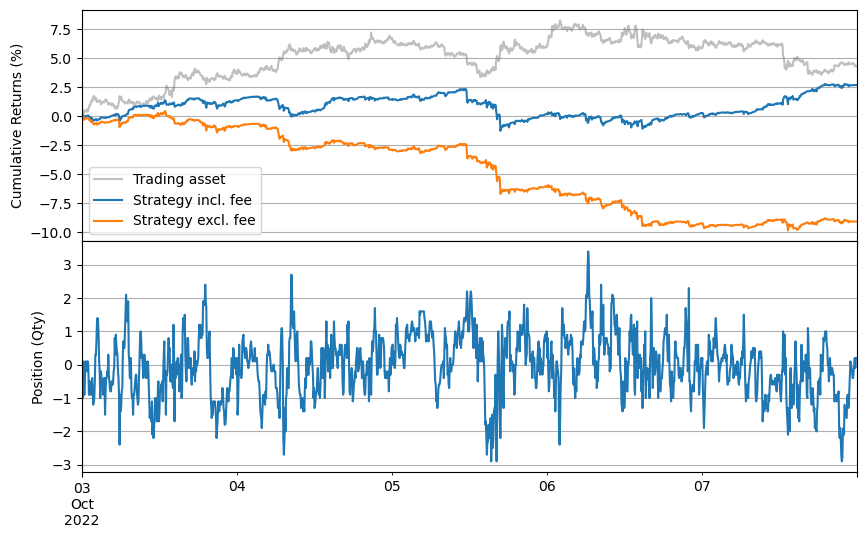

In [5]:
stat.summary(capital=2000)